In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import scale
import seaborn as sns
import pickle
from zmapio import ZMAPGrid
import warnings
warnings.filterwarnings("ignore")
import collections

In [2]:
plt.rcParams.update({'font.size': 16})

In [3]:
## loading data (31 wells)

f=open('stage_2_selected_wells.pkl','rb')
sel_wells=pickle.load(f)

In [4]:
## separating the well names and the logs. 

keys = [] 
values = [] 
items = sel_wells.items() 
for i in items: 
    keys.append(i[0]), values.append(i[1]) 

In [5]:
## combining the logs from different wells into one dataframe on the basis of the well names

df_combined=pd.concat(values, ignore_index=False,keys=keys)
df_combined=df_combined.reset_index(level=0)
df_combined=df_combined.rename(columns={'level_0':'WELL'})
df_combined.head()  ## this is our data but it needs cleaning

,WELL,PEFWS,GRWS,DENWS,DTWS,DRESWS
11008.0,ANASAZI `16` STATE 1,2.865,103.895,2.594,68.471,15.191
11008.5,ANASAZI `16` STATE 1,2.809,98.146,2.595,67.866,14.876
11009.0,ANASAZI `16` STATE 1,2.764,93.175,2.598,67.542,14.776
11009.5,ANASAZI `16` STATE 1,2.820,87.963,2.601,67.714,15.113
11010.0,ANASAZI `16` STATE 1,2.938,86.100,2.597,68.097,15.504


In [6]:
np.shape(df_combined)

(104615, 6)

In [7]:
## how many missing values does each log has?

df_combined.isnull().sum()

WELL          0
PEFWS     26500
GRWS      12269
DENWS     21112
DTWS      30658
DRESWS    21367
dtype: int64

In [8]:
## removing the missing values from the data

data=df_combined.dropna(axis=0)
np.shape(data)

(66286, 6)

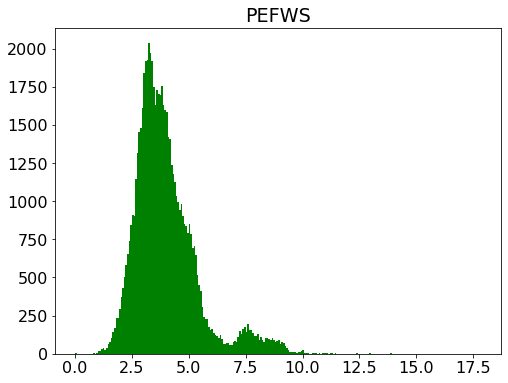

In [21]:
## checking how the distribution of each log look like in our data

plt.figure(figsize=[8,6])
plt.hist(data['PEFWS'], color='green', bins=250)
plt.title('PEFWS')
plt.show()

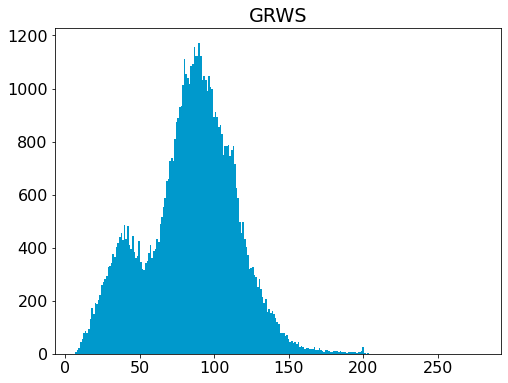

In [22]:
plt.figure(figsize=[8,6])
plt.hist(data['GRWS'], color='#0099cc', bins=250)
plt.title('GRWS')
plt.show()

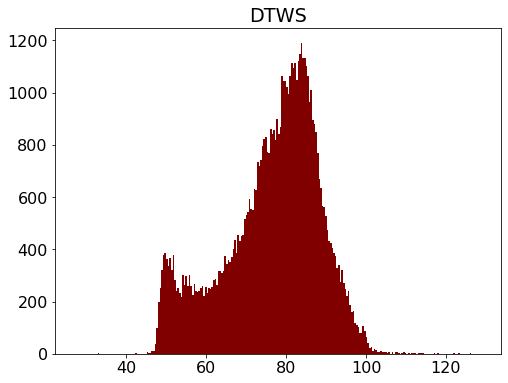

In [23]:
plt.figure(figsize=[8,6])
plt.hist(data['DTWS'], color='#800000', bins=250)
plt.title('DTWS')
plt.show()

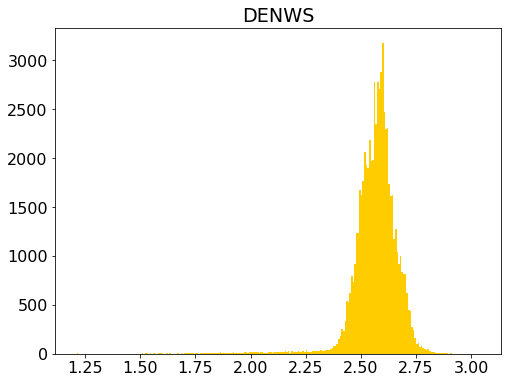

In [24]:
plt.figure(figsize=[8,6])
plt.hist(data['DENWS'], color='#ffcc00', bins=250)
plt.title('DENWS')
plt.show()

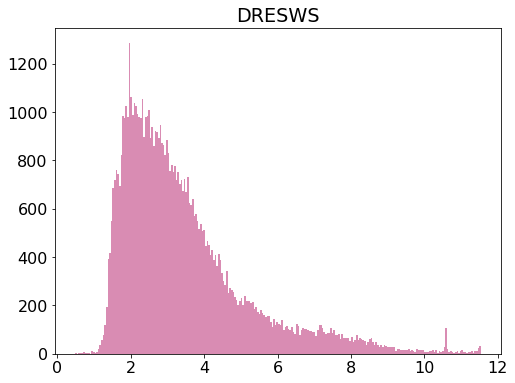

In [9]:
## this is a log scale as ressitivity varies over a large range (0 to 100,000 in this data)

plt.figure(figsize=[8,6])
plt.hist(np.log(data['DRESWS']), color='#d98cb3', bins=250)
plt.title('DRESWS')
plt.show()

In [13]:
np.e**10

22026.465794806703

In [14]:
data.loc[data['DRESWS']>22026]

,WELL,PEFWS,GRWS,DENWS,DTWS,DRESWS
12210.5,UNIVERSITY 20-16 1,2.340,62.397,1.468,78.724,100608.023
12211.0,UNIVERSITY 20-16 1,2.408,63.280,1.427,87.011,57596.867
12280.0,UNIVERSITY 20-16 1,1.798,87.922,1.262,69.972,97386.594
12280.5,UNIVERSITY 20-16 1,1.663,80.289,1.205,70.313,101750.578
12281.0,UNIVERSITY 20-16 1,1.648,71.090,1.204,71.151,101750.578
...,...,...,...,...,...,...
11796.5,ANGUS 7 STATE 1,3.228,74.367,2.621,54.318,47458.641
12091.5,MERCHANT 8 FEDERAL 1,4.369,46.334,2.601,62.213,40146.148
10108.0,WHITE CITY UNIT COM 2,5.601,37.782,2.749,49.000,62056.742
10124.0,WHITE CITY UNIT COM 2,4.943,79.187,2.691,53.428,60576.848


In [15]:
## we dont have a lot of outliers (very high or very low values) but we do have some. Lets get rid of those.

cleaned_data=data[(data.GRWS<=150)]
cleaned_data=cleaned_data[(cleaned_data.DTWS<=120)]
cleaned_data=cleaned_data[(cleaned_data.PEFWS>=1) & (cleaned_data.PEFWS<=10)]
cleaned_data=cleaned_data[(cleaned_data.DENWS>=1.95) & (cleaned_data.DENWS<=2.95)]
cleaned_data=cleaned_data[(cleaned_data.DRESWS<=22026)]

In [16]:
cleaned_data

,WELL,PEFWS,GRWS,DENWS,DTWS,DRESWS
11008.0,ANASAZI `16` STATE 1,2.865,103.895,2.594,68.471,15.191
11008.5,ANASAZI `16` STATE 1,2.809,98.146,2.595,67.866,14.876
11009.0,ANASAZI `16` STATE 1,2.764,93.175,2.598,67.542,14.776
11009.5,ANASAZI `16` STATE 1,2.820,87.963,2.601,67.714,15.113
11010.0,ANASAZI `16` STATE 1,2.938,86.100,2.597,68.097,15.504
...,...,...,...,...,...,...
10181.0,WHITE CITY UNIT COM 2,4.889,55.120,2.728,54.897,45.613
10181.5,WHITE CITY UNIT COM 2,4.442,68.090,2.734,55.661,25.452
10182.0,WHITE CITY UNIT COM 2,4.177,62.949,2.743,55.930,41.549
10182.5,WHITE CITY UNIT COM 2,3.884,47.851,2.753,55.993,127.334


In [19]:
## now we need the wolfcamp interval for each depth sample

wc_tops=pd.read_excel('Wolfcamp_top_depths.xlsx') 
wc_tops.head()

,Well Name,UWI,Operator,Surf X,Surf Y,Bot X,Bot Y,Datum,Surface_Topography,Top_Wolfcamp_(A),Top_Wolfcamp_B,Top_Wolfcamp_C,Top_Wolfcamp_D-upper,Top_Wolfcamp_D-middle,Top_Wolfcamp_D-lower,Base_Wolfcamp
0,RAYNOLDS HF U 2 1,42371104570000,CHEVRON U S A INCORPORATED,2262373.5,11311421.3,0.0,0.0,2678,-2630.359863,6269.718750,6730.954102,7192.188965,7251.905273,7710.336914,7838.768555,8168.768555
1,REED `17` 1,42371369920000,CHEVRON MIDCONTINENT LIMITED PARTNER,2274955.2,11324936.4,0.0,0.0,2606,-2557.271973,6469.093750,6720.343262,6971.592285,7022.848633,7740.823242,8128.798340,8458.798828
2,RAYNOLDS HF UNIT NO 2,42371106650000,CHEVRON U S A INCORPORATED,2262278.3,11315672.6,0.0,0.0,2672,-2624.295898,6232.437500,6702.802734,7173.167969,7211.698730,7496.133789,7497.633301,7780.569336
3,EMMA PARKE 1,42371033840000,TEXACO INCORPORATED,2276761.6,11245558.5,0.0,0.0,2879,-2855.939697,6012.042480,6365.622070,6719.201172,6944.966309,10413.910156,13552.854492,13882.854492
4,AUSTIN COLLEGE 8,42371303990000,TEXACO INCORPORATED PRODUCING DEPART,2287840.0,11261999.9,0.0,0.0,2797,-2785.416748,6283.688477,6626.311523,6968.933594,7180.927734,8996.265625,10481.604492,10811.604492


In [22]:
## lets get the 31 wells in our data

df_subset=wc_tops.loc[wc_tops['Well Name'].isin(keys)]
df_subset.head()

,Well Name,UWI,Operator,Surf X,Surf Y,Bot X,Bot Y,Datum,Surface_Topography,Top_Wolfcamp_(A),Top_Wolfcamp_B,Top_Wolfcamp_C,Top_Wolfcamp_D-upper,Top_Wolfcamp_D-middle,Top_Wolfcamp_D-lower,Base_Wolfcamp
6,PRICE ESTATE UNIT 1 3,42371367640000,CHEVRON MIDCONTINENT LIMITED PARTNER,2280607.0,11267636.3,0.0,0.0,2869,-2791.244385,6428.541016,6784.234863,7139.928711,7338.685059,9278.505859,10888.326172,11218.327148
80,TYRRELL W C UNIT 1 4,42371369230000,CHEVRON MIDCONTINENT LIMITED PARTNER,2277136.9,11272178.5,0.0,0.0,2814,-2792.053711,6585.788086,6927.629883,7269.471680,7458.567383,10016.037109,12243.508789,12573.509766
173,SCHLOSSER FRED ESTA 2-D,42371349660000,CHEVRON U S A INCORPORATED,2209224.3,11298339.1,0.0,0.0,2764,-2765.687256,7385.867676,7659.491211,7933.114746,8084.505859,10332.128906,12249.752930,12579.753906
188,UNIVERSITY 20-5 1,42301311930000,CHESAPEAKE OPERATING INCORPORATED,2152070.6,11524191.5,0.0,0.0,2839,-2804.203613,8883.484375,9242.458984,9601.433594,9820.436523,11474.937500,12799.440430,13129.439453
308,UNIVERSITY 10-18 `A 7,42475347500000,CHEVRON U S A INCORPORATED,2181957.9,11482911.2,0.0,0.0,2806,-2724.640625,8550.266602,8918.110352,9285.955078,9482.012695,10227.980469,10643.949219,10973.948242


In [24]:
## we want only some important columns like name, uwi, well coords etc

df_imp_col=df_subset[['Well Name', 'UWI', 'Surf X', 'Surf Y']]

df_imp_col['Top_WC_A']=df_subset['Top_Wolfcamp_(A)']+df_subset['Datum']
df_imp_col['Top_WC_B']=df_subset['Top_Wolfcamp_B']+df_subset['Datum']
df_imp_col['Top_WC_C']=df_subset['Top_Wolfcamp_C']+df_subset['Datum']
df_imp_col['Top_WC_D_up']=df_subset['Top_Wolfcamp_D-upper']+df_subset['Datum']
df_imp_col['Top_WC_D_low']=df_subset['Top_Wolfcamp_D-lower']+df_subset['Datum']
df_imp_col['Base_WC']=df_subset['Base_Wolfcamp']+df_subset['Datum']

np.shape(df_imp_col)


(31, 10)

In [25]:
## save
df_imp_col.to_pickle('stage_2_sel_well_intervals.pkl')

In [26]:
df_corrected=pd.read_pickle('stage_2_sel_well_intervals.pkl')

In [29]:
## including a column in our data marking the the wolfcamp interval at that depth

wells=[]
for well in keys:
    df_well=cleaned_data.loc[cleaned_data['WELL']==well]
    
    wc_a=df_corrected['Top_WC_A'].loc[df_corrected['Well Name']==well].item()
    wc_b=df_corrected['Top_WC_B'].loc[df_corrected['Well Name']==well].item()
    wc_c=df_corrected['Top_WC_C'].loc[df_corrected['Well Name']==well].item()
    wc_d1=df_corrected['Top_WC_D_up'].loc[df_corrected['Well Name']==well].item()
    wc_d2=df_corrected['Top_WC_D_low'].loc[df_corrected['Well Name']==well].item()
    wc_base=df_corrected['Base_WC'].loc[df_corrected['Well Name']==well].item()
    
    df_well['Interval']=0
    df_well['Interval'].loc[(df_well.index>=wc_a) & (df_well.index<wc_b)]='WC A'
    df_well['Interval'].loc[(df_well.index>=wc_b) & (df_well.index<wc_c)]='WC B'
    df_well['Interval'].loc[(df_well.index>=wc_c) & (df_well.index<wc_d1)]='WC C'
    df_well['Interval'].loc[(df_well.index>=wc_d1) & (df_well.index<wc_d2)]='WC D upper'
    df_well['Interval'].loc[(df_well.index>=wc_d2)]='WC D lower'
    
    wells.append(df_well)

In [30]:
grouped_data=pd.concat(wells, ignore_index=False)
grouped_data
    

,WELL,PEFWS,GRWS,DENWS,DTWS,DRESWS,Interval
11008.0,ANASAZI `16` STATE 1,2.865,103.895,2.594,68.471,15.191,WC A
11008.5,ANASAZI `16` STATE 1,2.809,98.146,2.595,67.866,14.876,WC A
11009.0,ANASAZI `16` STATE 1,2.764,93.175,2.598,67.542,14.776,WC A
11009.5,ANASAZI `16` STATE 1,2.820,87.963,2.601,67.714,15.113,WC A
11010.0,ANASAZI `16` STATE 1,2.938,86.100,2.597,68.097,15.504,WC A
...,...,...,...,...,...,...,...
10181.0,WHITE CITY UNIT COM 2,4.889,55.120,2.728,54.897,45.613,WC D lower
10181.5,WHITE CITY UNIT COM 2,4.442,68.090,2.734,55.661,25.452,WC D lower
10182.0,WHITE CITY UNIT COM 2,4.177,62.949,2.743,55.930,41.549,WC D lower
10182.5,WHITE CITY UNIT COM 2,3.884,47.851,2.753,55.993,127.334,WC D lower


In [31]:
grouped_data.to_pickle('stage_2_data_for_clustering.pkl')